In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install rouge

In [4]:
import os
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import collections
import random
import json
import pickle
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
import string
import numpy as np
from pickle import load
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM ,GRU
from keras.layers import Embedding
from keras.layers import Dropout, Reshape, Lambda, Concatenate
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

In [ ]:
# DO NOT RUN!

# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('/content/drive/MyDrive/ImageCaptioning/COCO') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('/content/drive/MyDrive/ImageCaptioning/COCO'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('/content/drive/MyDrive/ImageCaptioning/COCO') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('/content/drive/MyDrive/ImageCaptioning/COCO'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [ ]:
annotation_file = '/content/drive/MyDrive/ImageCaptioning/COCO/annotations/captions_train2014.json'
PATH = '/content/drive/MyDrive/ImageCaptioning/COCO/train2014/'

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
descriptions = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"{val['caption']}"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  descriptions[image_path].append(caption)

In [ ]:
def clean_data(pairs):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>0]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [ ]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['a very clean and well decorated empty bathroom',
 'a blue and white bathroom with butterfly themed wall tiles',
 'a bathroom with a border of butterflies and blue paint on the walls above it',
 'an angled view of a beautifully decorated bathroom',
 'a clock that blends in with the wall hangs in a bathroom']

In [ ]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [ ]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> a very clean and well decorated empty bathroom <endseq>',
 '<startseq> a blue and white bathroom with butterfly themed wall tiles <endseq>',
 '<startseq> a bathroom with a border of butterflies and blue paint on the walls above it <endseq>',
 '<startseq> an angled view of a beautifully decorated bathroom <endseq>',
 '<startseq> a clock that blends in with the wall hangs in a bathroom <endseq>']

In [ ]:
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which appear at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    return vocab

In [ ]:
vocab = create_reoccurring_vocab(descriptions, word_count_threshold = 5)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'aa',
 'abandon',
 'abandoned',
 'ability',
 'able',
 'aboard',
 'about']

In [ ]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # to make sure all the last non digit non alphabet chars are removed
tokenizer = keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)
#pickle.dump(tokenizer, open('/content/drive/MyDrive/ImageCaptioning/COCO/word_tokenize.pkl', 'wb'))

vocab_size : 8794


In [ ]:
# RUN THISSSSSS
with open('/content/drive/MyDrive/ImageCaptioning/COCO/word_tokenize.pkl','rb') as f:
    tokenizer = pickle.load(f)  

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

In [ ]:
dict(descriptions)
img_keys = list(descriptions.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys)*0.9)

train_descriptions = dict(list(descriptions.items())[:slice_index])
test_descriptions = dict(list(descriptions.items())[slice_index:])
len(train_descriptions),len(test_descriptions)

(74504, 8279)

In [ ]:
train_descriptions = dict(list(descriptions.items())[:slice_index])
test_descriptions = dict(list(descriptions.items())[slice_index:])

In [ ]:
#pickle.dump(train_descriptions, open('/content/drive/MyDrive/ImageCaptioning/COCO/data/train_descriptions.pkl', 'wb'))
#pickle.dump(test_descriptions, open('/content/drive/MyDrive/ImageCaptioning/COCO/data/test_descriptions.pkl', 'wb'))

In [ ]:
with open('/content/drive/MyDrive/ImageCaptioning/COCO/data/train_descriptions.pkl','rb') as f:
    train_descriptions = pickle.load(f)  

with open('/content/drive/MyDrive/ImageCaptioning/COCO/data/test_descriptions.pkl','rb') as f:
    test_descriptions = pickle.load(f)  

In [ ]:
print(next(iter(train_descriptions)), train_descriptions[next(iter(train_descriptions))])

x = plt.imread( next(iter(train_descriptions)) )
plt.imshow(x)
plt.show()

/content/drive/MyDrive/ImageCaptioning/COCO/train2014/COCO_train2014_000000318556.jpg ['<startseq> a very clean and well decorated empty bathroom <endseq>', '<startseq> a blue and white bathroom with butterfly themed wall tiles <endseq>', '<startseq> a bathroom with a border of butterflies and blue paint on the walls above it <endseq>', '<startseq> an angled view of a beautifully decorated bathroom <endseq>', '<startseq> a clock that blends in with the wall hangs in a bathroom <endseq>']


In [ ]:
# finding the maximum length of questions and answers
def max_length(desc,p):
    all_desc = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_desc.append(j)

    length_all_desc = list(len(d.split()) for d in all_desc)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_desc, p)))
    print('longest sentence: ', max(length_all_desc))

    return int(np.percentile(length_all_desc, p))

max_length = max_length(train_descriptions,90)
print('max-len answer for training: ', max_length)

percentile 90 of len of questions: 15.0
longest sentence:  51
max-len answer for training:  15


In [ ]:
inception = InceptionV3()
extractor = Model(inputs=inception.inputs, outputs=inception.layers[-2].output) # removing 2 last fully connected layers 
print(extractor.summary())

96124928/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
def extract_features(description, model, inpute_size = (299,299)):
    features = {}
    for name in tqdm(description):
        image = load_img(name, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        features[name] = feature.reshape(2048)
    return features

In [ ]:
#train_features = extract_features(train_descriptions, extractor)
#test_features = extract_features(test_descriptions, extractor)

#pickle.dump(train_features, open('/content/drive/MyDrive/ImageCaptioning/COCO/train_features.pkl', 'wb'))
#pickle.dump(test_features, open('/content/drive/MyDrive/ImageCaptioning/COCO/test_features.pkl', 'wb'))

In [ ]:
# RUN THIS
with open('/content/drive/MyDrive/ImageCaptioning/COCO/train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('/content/drive/MyDrive/ImageCaptioning/COCO/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

In [ ]:
batch_size = 64
emb_dim = 100

In [ ]:
# outputs a batch of captions-pictures
def data_generator(description, photos):
    X1, X2, y = [], [], []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in description.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # find the index of each word of the caption in vocabulary
                seq = tokenizer.texts_to_sequences(desc.split())
                # split one sequence into multiple X, y pairs
                # Loop: selects one word from the caption,
                # consider that word as y and
                # all the words before that will be the X
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == batch_size:
                yield [[np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
d = next(data_generator(test_descriptions, test_features))
d[0][0].shape, d[0][1].shape, d[1].shape

((3856, 2048), (3856, 15), (3856,))

In [ ]:
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # just a zero matrix 
    else:
        glove_dir = '/content/drive/MyDrive/ImageCaptioning/glove/'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get x-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_size, embedding_dim)) # Keras Embedding layer - all 0
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        print('GloVe loaded!')
        
    embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

In [ ]:
embedding_layer = make_embedding_layer(emb_dim, glove=True)

GloVe loaded!


In [ ]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
from keras.layers import RepeatVector
def make_model(embedding ,dout= 0.2, feature_size= 2048, units= 512):
    
    features = Input(shape=(feature_size,)) # output size of feature extractor
    X_fe_one_dim = Dense(units, activation='relu')(features) 
    X_fe = RepeatVector(max_length)(X_fe_one_dim)
    X_fe = Dropout(0.2)(X_fe)
    
    seq = Input(shape=(max_length,))
    X_seq = embedding(seq)
    X_seq = Lambda(lambda x: x, output_shape=lambda s:s)(X_seq) # remove mask from the embedding cause concat doesn't support it
    X_seq = Dropout(0.2)(X_seq)
    X_seq = Concatenate(axis=-1)([X_fe,X_seq])
    X_seq = LSTM(units, return_sequences=True)(X_seq,initial_state=[X_fe_one_dim,X_fe_one_dim]) # passing features as init_state
    X_seq = Dropout(0.5)(X_seq)
    X_seq = LSTM(units, return_sequences=False)(X_seq)

    outputs = Dense(vocab_size, activation='softmax')(X_seq)

    # merge the two input models
    model = Model(inputs=[features, seq], outputs = outputs, name='model_with_features_each_step')
    return model

In [ ]:
model = make_model(embedding_layer)
model.summary()

Model: "model_with_features_each_step"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          1049088     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 15, 100)      879400      ['input_3[0][0]']                
                                                                      

In [ ]:
model.compile(loss=masked_loss_function, optimizer= 'RMSProp')

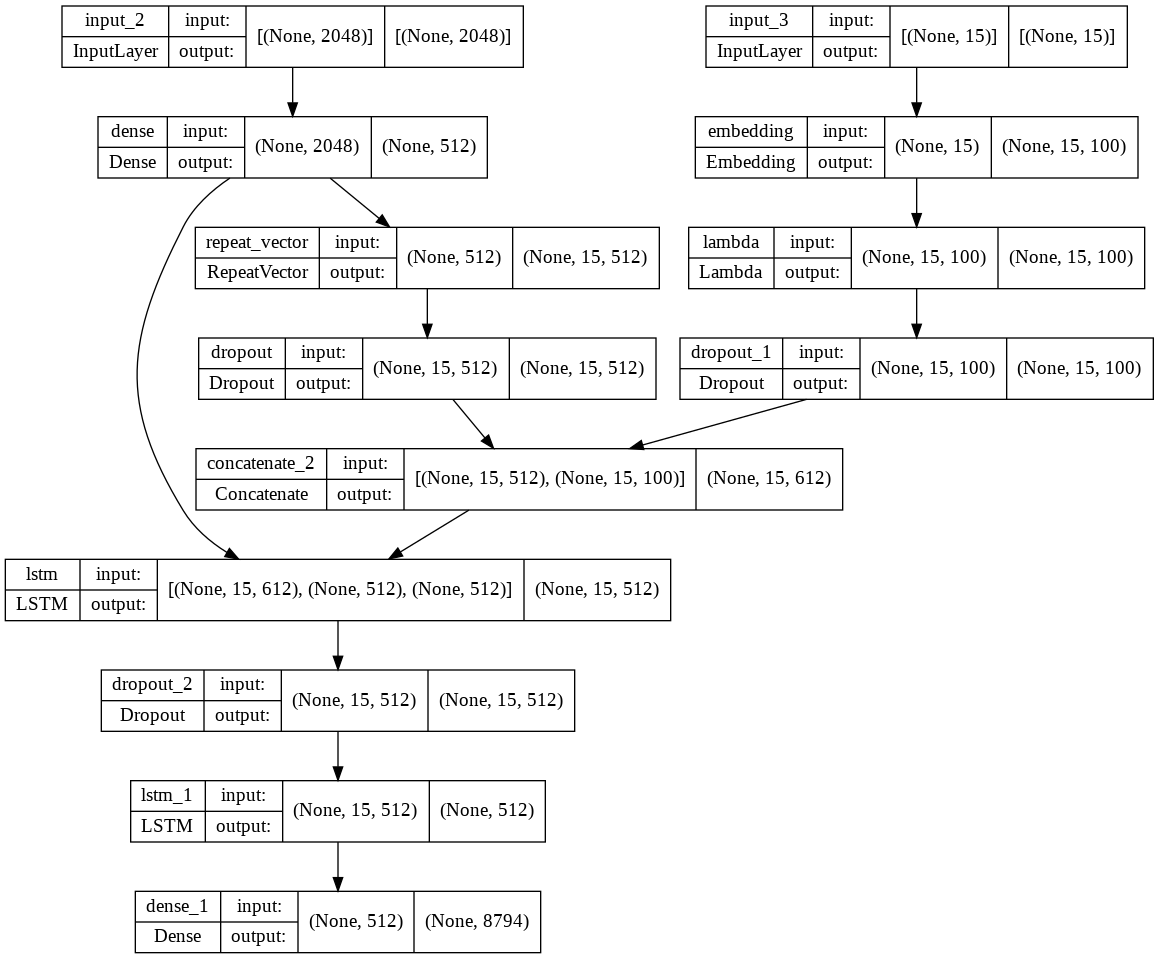

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
history={'loss':[], 'BLEU_val':[]}

In [ ]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, inference= False):
    # seed the generation process
    in_text = start_token
    # iterate over the whole length of the sequence
    # generate one word at each iteratoin of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences(in_text.split()) #[wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == end_token:
            break
            
    if inference == True:
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:] # if it is already at max len and endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)
        
    return in_text

In [ ]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
def calculate_rouge_score(actual, predict):
    actual_cap, pred_cap = list(), list()
    for tmp_1 in actual:
        for tmp_2 in tmp_1:
          actual_cap.append(tmp_2)

    for i in range(len(predict)):
        temp = []
        for j in range(5):
            temp.append(predict[i])
        pred_cap = pred_cap + temp

    rouge = Rouge()
    score = rouge.get_scores(hyps = pred_cap, refs = actual_cap, avg=True)
    return score

In [ ]:
# calculating BLEU score of predictions
def evaluate_model(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    actual_r, predicted_r = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(descriptions.items()):
        # generate description
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        # store actual and predicted
        references = [d.split() for d in desc_list[:5]]
        actual.append(references)
        predicted.append(yhat.split())

        actual_r.append([d for d in desc_list[:5]])
        predicted_r.append(yhat)

    # calculate Rouge score
    score = calculate_rouge_score(actual_r, predicted_r) 
    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    print('ROUGE: ', score)
    return [b1,b2,b3,b4,score]

In [ ]:
def test(i=np.random.randint(len(test_features)), j=np.random.randint(len(test_features)),
         k=np.random.randint(len(test_features)), q=np.random.randint(len(test_features)), show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread(pic)
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[j]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread(pic)
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[k]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread(pic)
        plt.imshow(x)
        plt.show()
    print("Greedy:", generate_desc(model, fe, inference=True))
    pic = list(test_features.keys())[q]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread(pic)
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    print('====') 

test()

====
Greedy: seniors headphone headphone pandas pandas pandas pandas pandas pandas pandas head head head head
Greedy: deflated deflated stands stands soapy soapy soapy soapy soapy skii skii soapy soapy soapy
Greedy: monogrammed monogrammed monogrammed hortons hortons hortons subs stems subs hortons squared squared squared squared
Greedy: covered channel subs subs subs microphone frosting frosting frosting frosting frosting frosting frosting frosting
====


In [ ]:
weight_folder = '/content/drive/MyDrive/ImageCaptioning/COCO/lstm_512/'

In [ ]:
import keras
from keras.callbacks import ReduceLROnPlateau
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 2 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(weight_folder+"model_{}.h5".format(epoch))
            test()

saver = CustomSaver()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)

In [ ]:
steps = len(train_descriptions)//batch_size

# create the data generator
generator = data_generator(train_descriptions, train_features)

In [ ]:
# DONT RUN AGAIN
#h = model.fit(generator, epochs=100, steps_per_epoch=steps, verbose=1, callbacks=[early_stopping, reduce_lr, saver])
history['loss'].append(h.history['loss'])

Epoch 1/100
1164/1164 [==============================] - ETA: 0s - loss: 3.4697====
Greedy: a plate of food with a fork and a fork
Greedy: a teddy bear sitting on a bed with a teddy bear
Greedy: a person holding a cell phone and a laptop
Greedy: a woman holding a cell phone while standing in front of a window <endseq>
====
1164/1164 [==============================] - 680s 578ms/step - loss: 3.4697 - lr: 0.0010
Epoch 2/100
1164/1164 [==============================] - 675s 580ms/step - loss: 2.8475 - lr: 0.0010
Epoch 3/100
1164/1164 [==============================] - ETA: 0s - loss: 2.7055====
Greedy: a plate of food with a fork and a fork
Greedy: a teddy bear with a teddy bear in its mouth
Greedy: a person holding a cell phone in their hand
Greedy: a woman with a cell phone in his hand
====
1164/1164 [==============================] - 677s 582ms/step - loss: 2.7055 - lr: 0.0010
Epoch 4/100
1164/1164 [==============================] - 675s 580ms/step - loss: 2.6343 - lr: 0.0010
Epoch 5/1

In [ ]:
# DO NOT RUN
import pickle
history = h.history['loss']
with open('/content/drive/MyDrive/ImageCaptioning/COCO/history_image_caption.pkl','wb') as f:
    pickle.dump(history, f) 

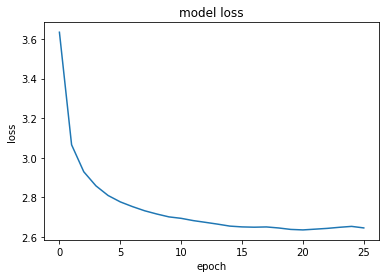

In [5]:
with open('/content/drive/MyDrive/ImageCaptioning/COCO/history_image_caption.pkl','rb') as f:
    history= pickle.load(f)  

# summarize history for loss
plt.plot(history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [8]:
dict = {'score': history}  
import pandas as pd     
df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('GFG.csv') 

In [ ]:
# CHANGE "i" TO LOAD MODELS
i = 16
model = keras.models.load_model(weight_folder+f'model_{i}.h5', compile=False)

In [ ]:
evaluate_model(model, test_descriptions, test_features, K_beams=1)

  0%|          | 35/8279 [00:35<2:20:56,  1.03s/it]


KeyboardInterrupt: ignored

In [ ]:
i = 0
while(i < 50):
  pic = list(test_features.keys())[np.random.randint(1,1000)]
  fe = test_features[pic].reshape((1,2048))
  x = plt.imread(pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",generate_desc(model, fe, inference=True))
  print("Beam K= 3:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 3, log=False))
  print("Beam K= 5:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 5, log=False))
  print("Beam K= 7:",beam_search_pred(model, test_features[pic], wordtoix, K_beams = 7, log=False))
  i += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def predict(path):
  pic = load_img(path, target_size=(299,299))
  image = img_to_array(pic)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  feature = extractor.predict(image, verbose=0)

  fe = feature.reshape((1,2048))
  x = plt.imread(path)
  plt.imshow(x)
  plt.show()
  print("Greedy:",generate_desc(model, fe, inference=True))
  print("Beam K= 3:",beam_search_pred(model, fe, wordtoix, K_beams = 3, log=False))
  print("Beam K= 5:",beam_search_pred(model, fe, wordtoix, K_beams = 5, log=False))
  print("Beam K= 7:",beam_search_pred(model, fe, wordtoix, K_beams = 7, log=False))
  print("Beam K= 9:",beam_search_pred(model, fe, wordtoix, K_beams = 9, log=False))

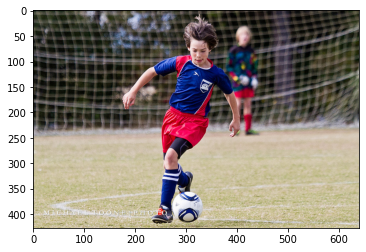

Greedy: a young boy kicking a soccer ball on a field
Beam K= 3: a young boy kicking a soccer ball during a game
Beam K= 5: a young boy kicking a soccer ball during a game
Beam K= 7: there is a young boy playing with a soccer ball
Beam K= 9: there is a young boy playing with a soccer ball


In [ ]:
predict('/content/COCO_train2014_000000581297.jpg')

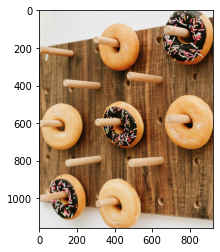

Greedy: a bunch of different types of different kinds of donuts
Beam K= 3: a close up of a bunch of different kinds of food
Beam K= 5: a close up of lots of different kinds of food
Beam K= 7: a close up of lots of different kinds of <UNK>


In [ ]:
predict('/content/download (1).jpeg')

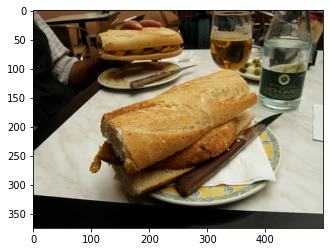

Greedy: a sandwich with fries and a side of fries
Beam K= 3: a close up of a plate of food on a table
Beam K= 5: a close up of a sandwich on a plate on a table
Beam K= 7: a close up of a sandwich on a plate on a table
Beam K= 9: a close up of a sandwich on a plate on a table


In [ ]:
predict('/content/COCO_train2014_000000581670.jpg')

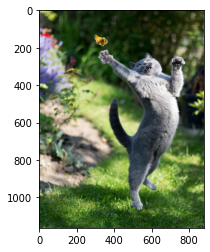

Greedy: a dog is holding a ball in its mouth
Beam K= 3: a close up of a dog playing with a ball
Beam K= 5: a close up of a dog playing with a ball
Beam K= 7: a close up of a dog playing with a ball


In [ ]:
predict('/content/test.jpeg')

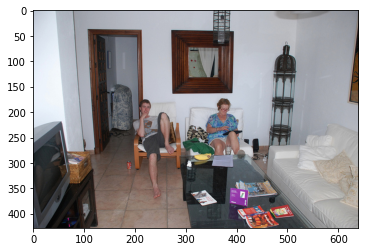

Greedy: a group of people sitting around a living room together
Beam K= 3: a group of people that are sitting in a living room
Beam K= 5: a group of people sitting next to each other in a living room
Beam K= 7: a group of people sitting next to each other in a living room


In [ ]:
predict('/content/COCO_train2014_000000581637.jpg')

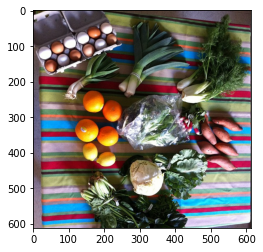

Greedy: a pile of different types of different colored vegetables
Beam K= 3: a bunch of different types of vegetables on a table
Beam K= 5: a pile of vegetables sitting on top of a counter
Beam K= 7: a pile of vegetables sitting on top of a cutting board
Beam K= 9: a pile of vegetables sitting on top of a cutting board


In [ ]:
predict('/content/COCO_train2014_000000580735.jpg')

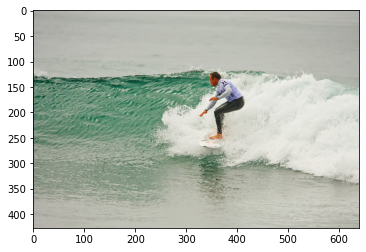

Greedy: a man riding a wave on top of a surfboard
Beam K= 3: a person on a surf board riding a wave
Beam K= 5: a man riding a wave on top of a surfboard
Beam K= 7: a man riding a wave on top of a surfboard
Beam K= 9: a person riding a surf board on a body of water


In [ ]:
predict('/content/COCO_train2014_000000580887.jpg')

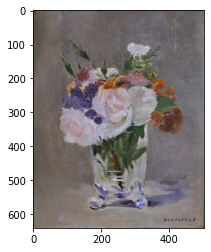

Greedy: a vase filled with flowers and a vase of flowers
Beam K= 3: a vase filled with purple flowers in a vase
Beam K= 5: a vase filled with purple flowers in a vase
Beam K= 7: a close up of a teddy bear in a glass vase
Beam K= 9: a close up of a teddy bear in a glass vase


In [ ]:
predict('/content/COCO_train2014_000000580790.jpg')

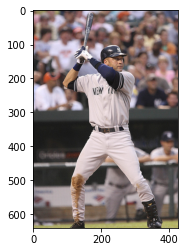

Greedy: a baseball player holding a bat on a field
Beam K= 3: a baseball player holding a bat on top of a field
Beam K= 5: a baseball player holding a bat during a game
Beam K= 7: a baseball player getting ready to hit a ball
Beam K= 9: a baseball player holding a bat during a game


In [ ]:
predict('/content/COCO_train2014_000000579901.jpg')

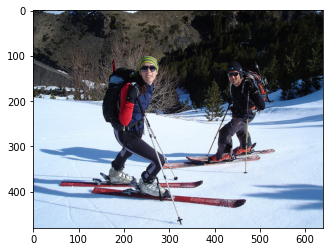

Greedy: a man and a woman are standing in the snow
Beam K= 3: a couple of people that are standing in the snow
Beam K= 5: a couple of people that are standing in the snow
Beam K= 7: a couple of people that are standing in the snow
Beam K= 9: a couple of people that are standing in the snow


In [ ]:
predict('/content/COCO_train2014_000000579136.jpg')

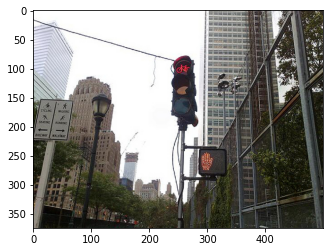

Greedy: a man is standing on a sidewalk with a sign
Beam K= 3: a person standing on a road holding a cell phone
Beam K= 5: a group of people that are standing in the street
Beam K= 7: a group of people standing next to each other on a street
Beam K= 9: a couple of men standing next to each other on a street


In [ ]:
predict('/content/COCO_train2014_000000578748.jpg')

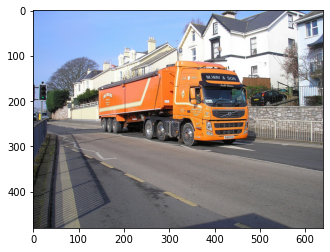

Greedy: a large truck with a lot of stuff on it
Beam K= 3: a truck that is parked on the side of the road
Beam K= 5: there is a truck that is parked on the side of the road
Beam K= 7: there is a truck that is parked on the side of the road
Beam K= 9: there is a truck that is parked on the side of the road


In [ ]:
predict('/content/COCO_train2014_000000577835.jpg')